# XAI for exploratory analysis

In [1]:
import pandas as pd
from typing import *
from src.preprocess.dataset import Dataset, DatasetConfig
from src.preprocess.result import ResultData


# Usage Example:

dataset_names: Optional[List[str]]

result_data = ResultData(
    datadict = True, # Optional[Dict[str, pd.DataFrame]]
    ml_ready = True, # Optional[pd.DataFrame]
    metadata = True  # Optional["Metadata"]
    )

dataset = Dataset(DatasetConfig(use_raw=False))

result_data = dataset.get(result_data)


In [2]:
# dictionary with key=names : value=dataframe

"""
{"feature1" : dataframe}

frames in format:
year | country1 | country2 ...
2019 | value1   | value2   
"""

datadict : Dict[str, pd.DataFrame] = result_data.datadict

for key in list(datadict.keys()): 
    print(f"{key}") 

individuals_using_the_internet_percent_of_population
net_trade_in_goods_and_services_current_usd
fdi_net_inflows_current_usd
area
education_years
services_value_added_percent_of_gdp
manufacturing_value_added_percent_of_gdp
total_population
economic_activity
life_expectancy_at_birth_total_years
gdp_per_person_employed_constant_2011_ppp_usd
population_size
petroleum_energy_production
renewables_excluding_hydro_share
hydro_electric_energy_production
gas_energy_production
coal_energy_production
consumer_price_index_change
unemployment_rate_percent_of_total_labor_force
gdp_current_usd


In [3]:
from src.clean.health_check import health_check_datadict, print_health_anomalies

report = health_check_datadict(datadict)
print_health_anomalies(report)



In [4]:

imputed = result_data.ml_ready
print("Missing after imputation:", imputed.isna().sum().sum())  # should be 0


Missing after imputation: 0


In [5]:
from sklearn.preprocessing import StandardScaler
from src.preprocess.forecast_dataset import ForecastConfig, ForecastDataset
from src.model.train_forecast import train_forecast

import pandas as pd

lengths = imputed.groupby('country').size().sort_values()

# 1) pick numeric features & label
label_col = "gdp_current_usd"
num_cols  = imputed.select_dtypes(include="number").columns.tolist()
feat_cols = [c for c in num_cols if c != label_col]

# 2) fit two scalers:
#  - panel_scaler on feat_cols only
panel_scaler = StandardScaler().fit(imputed[feat_cols].values)
#  - window_scaler on feat_cols+label_col
window_scaler = StandardScaler().fit(
    imputed[feat_cols + [label_col]].values
)

# 3) build config
cfg = ForecastConfig(
    window_size   = 10,
    horizon       = 1,
    feat_cols     = feat_cols,
    label_col     = label_col,
    group_col     = "country",
    date_col      = "date",
    val_frac      = 0.1,
    test_frac     = 0.1,
    batch_size    = 64,
    panel_scaler  = panel_scaler,
    window_scaler = window_scaler,
)


# PANEL loader for SHAP ([B, C, F])
panel_loader = ForecastDataset.make_panel_loader(imputed, cfg)

# SLIDING-WINDOW loaders for LSTM forecasting
train_loader, val_loader, test_loader = ForecastDataset.make_sliding_loaders(imputed, cfg)

(
    model, 
    (train_loader, val_loader, test_loader)
) = train_forecast(
    train_loader=train_loader, 
    val_loader=val_loader, 
    test_loader=test_loader,
    feat_cols=feat_cols,
    label_col=label_col,
    window_size = 30,
    horizon     =  1,
    val_frac    = 0.1,
    test_frac   = 0.1,
    batch_size  = 64,
    max_epochs  = 10000,
    patience    = 30,
    lr          = 1e-4
)

2025-05-21 00:49:04,560 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 1/10000 train=1.4130 val=0.8872
2025-05-21 00:49:04,839 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 2/10000 train=1.3686 val=0.8419
2025-05-21 00:49:05,077 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 3/10000 train=1.3050 val=0.7758
2025-05-21 00:49:05,313 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 4/10000 train=1.2055 val=0.6628
2025-05-21 00:49:05,544 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 5/10000 train=1.0640 val=0.5432
2025-05-21 00:49:05,825 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 6/10000 train=0.9096 val=0.4599
2025-05-21 00:49:06,098 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 7/10000 train=0.7784 val=0.4050
2025-05-21 00:49:06,364 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 8/10000 train=0.6867 val=0.3580
2025-05-21 00:49:06,653 - [train_forecast.] - [I

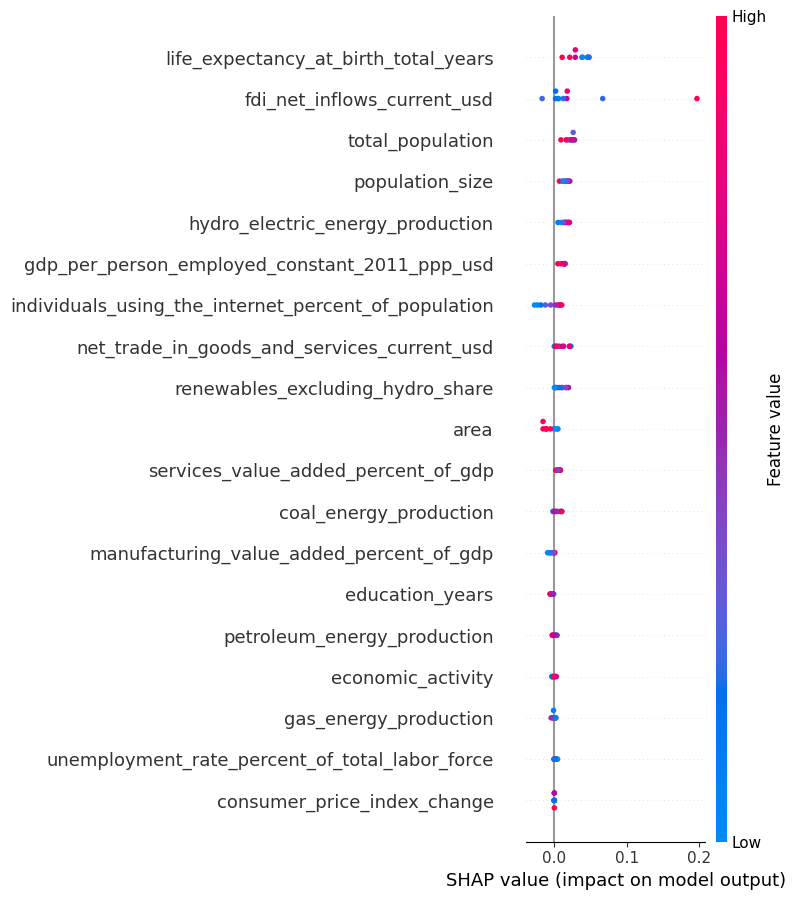

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # CPU‐only

import random
import numpy as np
import torch
import shap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

model.cpu().eval()

B = 32
bg_loader = DataLoader(train_loader.dataset, batch_size=B, shuffle=False)
bg_X, _  = next(iter(bg_loader))    # now guaranteed to work
bg_X = bg_X.detach().cpu()           # shape: (B, time, F)

explainer = shap.GradientExplainer(
    model,
    bg_X,
    local_smoothing=0
)

Xs, _ = next(iter(test_loader))
Xs = Xs.detach().cpu()

s3d = explainer.shap_values(Xs)[0]    # (time, F, 1)
s2d = np.squeeze(s3d, axis=-1)        # (time, F)
X_2d = Xs.mean(dim=0).numpy()         # (time, F)

assert s2d.shape == X_2d.shape == (Xs.shape[1], len(feat_cols)), (
    f"shapes mismatch: s2d={s2d.shape}, X_2d={X_2d.shape}, #feat_cols={len(feat_cols)}"
)

plt.figure(figsize=(14, 0.35 * len(feat_cols) + 2))
rng = np.random.RandomState(123)
shap.summary_plot(
    s2d,
    X_2d,
    feature_names=feat_cols,
    plot_type="dot",
    max_display=len(feat_cols),
    show=False,
    rng=rng
)
plt.tight_layout()
plt.show()
